In [1]:
#Uncomment following lines if running in Google Colab 
! pip install -q 'gwosc==0.5.4'
! pip install -q 'gwpy==2.0.2'
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf -P data/
! pip install -q 'PyCBC==1.18.0' 'lalsuite==6.82'

Reason for being yanked: Metadata is broken
     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 51 kB 957 kB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 3.6 MB 43.1 MB/s 
--2022-02-15 01:01:13--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘data/challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  23.8MB/s    in 68s     

2022-02-15 01:02:21 (3.62 MB/s) - ‘data/challenge3.gwf’ saved [256815066/256815066]

     |████████████████████████████████| 6.3 MB 5.5 MB/s 
     |████████████████████████████████| 27.3 MB 1.3 MB/s 
     |████████████████████████████████| 201 kB 74.9 MB/s 
     |█████████████

In [2]:
#imports
import gwosc
import gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
%matplotlib inline
from pycbc.waveform import get_td_waveform
from pycbc import frame
import pylab
import numpy
from pycbc.filter import highpass, matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

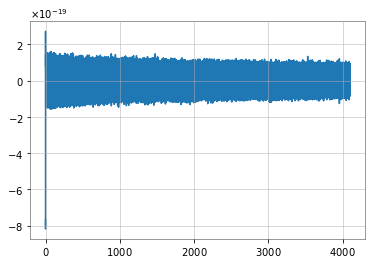

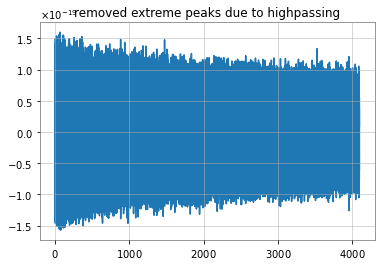

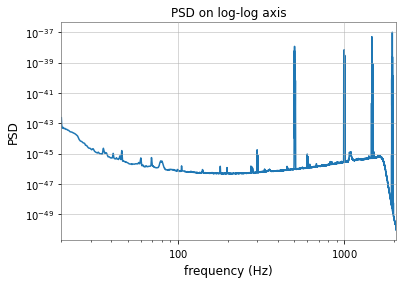

In [3]:
#it is easier to have the data imported by pycbc
data = frame.read_frame('data/challenge3.gwf', 'H1:CHALLENGE3')
sample_rate = data.sample_rate
#Let the time start at 0s instead of -64s
# data.start_time = 0

#removing frequencies lower than 20Hz
data = highpass(data,20)
pylab.plot(data.sample_times,data)

#the plot looks weird, extreme peaks at the start due to highpassing so we need to remove that
data = data.crop(2,2)
pylab.figure()
pylab.title('removed extreme peaks due to highpassing')
pylab.plot(data.sample_times,data)
pylab.show
# 4 second samples are chosen for the PSD
sample_length = 4
PSD = data.psd(sample_length)
#interpolating the PSD to match our data
PSD = interpolate(PSD,data.delta_f)


#1/PSD will act as the filter, we need to keep in mind that the data has been highpassed above 20Hz
PSD = inverse_spectrum_truncation(PSD,int(sample_length * sample_rate),low_frequency_cutoff=20)
#plot the PSD on log-log axis
pylab.figure()
pylab.plot(PSD.sample_frequencies,PSD)
pylab.xlim(20,sample_rate/2)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('frequency (Hz)')
pylab.ylabel('PSD')
pylab.title('PSD on log-log axis')
pylab.show()


In [4]:
#now making a template wave function using the info that is given
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=data.delta_t,
                         f_lower=20)
#resize to match the size of the data
hp.resize(len(data))
hc.resize(len(data))
#in order to make the SNR time series to match the merger we need to shift the wave functions so that the merger in the wave functions occurs in the first data bin
hp_shifted = hp.cyclic_time_shift(hp.start_time)
hc_shifted = hc.cyclic_time_shift(hc.start_time)

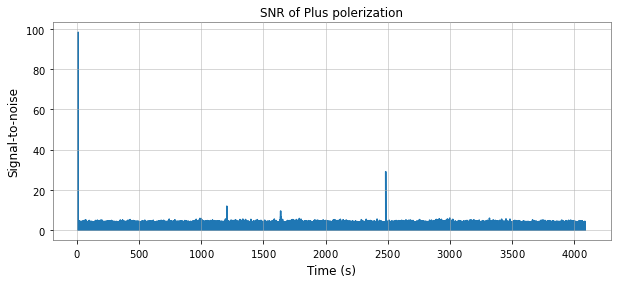

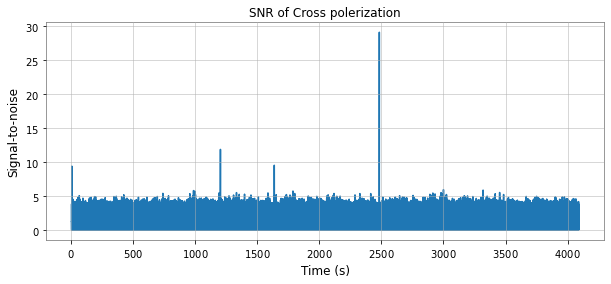

Plus polerization: Signal found at 7.973388671875s with SNR 98.39396231567133
Cross polerization: Signal found at 2483.967529296875s with SNR 29.093505848309306


In [5]:
#compute the SNR by using matched_filter
snr_p = matched_filter(hp_shifted, data, psd=PSD, low_frequency_cutoff=20)
snr_c = matched_filter(hc_shifted,data, psd=PSD, low_frequency_cutoff=20)

#remove time corruption due to filtering
snr_p = snr_p.crop(4,4)
snr_c = snr_c.crop(4,4)

#plot the SNR for both the plus and cross polerization
pylab.figure(figsize=[10, 4])
pylab.plot(snr_p.sample_times, abs(snr_p))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title('SNR of Plus polerization')
pylab.show()

pylab.figure(figsize=[10,4])
pylab.plot(snr_c.sample_times,abs(snr_c))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title('SNR of Cross polerization')
pylab.show()

#extract the height and time of the peak in SNR (as there is a high signal to noise ratio there, so there is likely a signal there)
peak = abs(snr_p).numpy().argmax()
snrp = snr_p[peak]
time = snr_p.sample_times[peak]
print("Plus polerization: Signal found at {}s with SNR {}".format(time, abs(snrp)))
peak2 = abs(snr_c).numpy().argmax()
snrp2 = snr_c[peak2]
time2 = snr_c.sample_times[peak2]
print("Cross polerization: Signal found at {}s with SNR {}".format(time2, abs(snrp2)))

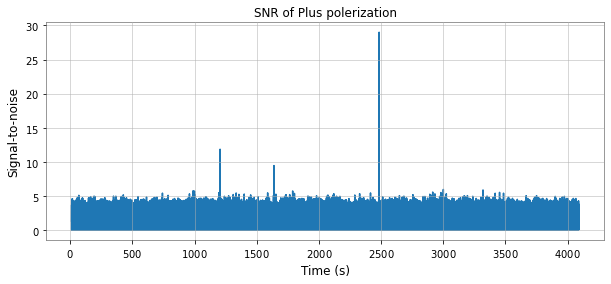

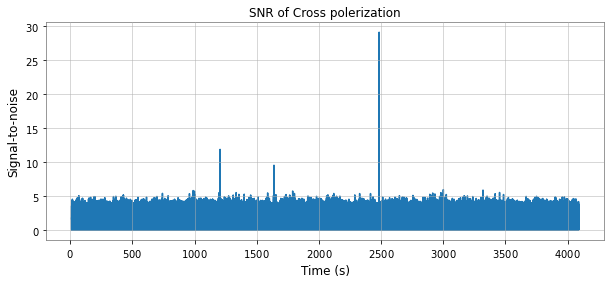

Plus polerization: Signal found at 2483.967529296875s with SNR 29.009069148336227
Cross polerization: Signal found at 2483.967529296875s with SNR 29.093505848309306


In [6]:
#seems highly unlikely that the signal is at t=7.9s, the peak in SNR of plus polerization is extremely high which is very unlikely
#there is also a massive difference in SNR between plus and cross polerization, so the peak at the start is most likely corruption from applying the filters
#therefore more cropping needs to be applied on the SNR to remove this corruption
#once that is done we can plot the SNR again
#remove time corruption due to filtering
snr_p = snr_p.crop(4,0)
snr_c = snr_c.crop(4,0)

#plot the SNR for both the plus and cross polerization
pylab.figure(figsize=[10, 4])
pylab.plot(snr_p.sample_times, abs(snr_p))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title('SNR of Plus polerization')
pylab.show()

pylab.figure(figsize=[10,4])
pylab.plot(snr_c.sample_times,abs(snr_c))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title('SNR of Cross polerization')
pylab.show()

#extract the height and time of the peak in SNR (as there is a high signal to noise ratio there, so there is likely a signal there)
peak = abs(snr_p).numpy().argmax()
snrp = snr_p[peak]
time = snr_p.sample_times[peak]
print("Plus polerization: Signal found at {}s with SNR {}".format(time, abs(snrp)))
peak2 = abs(snr_c).numpy().argmax()
snrp2 = snr_c[peak2]
time2 = snr_c.sample_times[peak2]
print("Cross polerization: Signal found at {}s with SNR {}".format(time2, abs(snrp2)))

In [7]:
#the merger time is at approximatly 2384s and the matched filtered SNR of the signal is 29